# **Scikit-learn - Cross Validation Search (GridSearchCV) and Hyperparameter Optimisation Regression**

## Objectives

* Learn and use GridSearchCV for Hyperparameter Optimisation




---

# Change working directory

* We are assuming you will store the notebooks in a subfolder, therefore when running the notebook in the editor, you will need to change the working directory

We need to change the working directory from its current folder to its parent folder
* We access the current directory with os.getcwd()

In [ ]:
import os
current_dir = os.getcwd()
current_dir

We want to make the parent of the current directory the new current directory
* os.path.dirname() gets the parent directory
* os.chir() defines the new current directory

In [ ]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

Confirm the new current directory

In [ ]:
current_dir = os.getcwd()
current_dir

## Cross Validation Search (GridSearchCV) and Hyperparameter Optimisation


Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

In this notebook I will be exploring how to perform hyperparameter optimisation for one algorithm and for multiple algorithms simultaneously.


### Hyperparameter Optimisation with one algorithm

In this section, we will select a given algorithm and fine-tune it, by defining a set of hyperparameters.

* A set of models will be fitted for each possible hyperparameter combination based on the cross-validation parameter. For example, if the developer sets cross-validation to 5, it will fit five models for a given hyperparameter combination.
* These five models are scored against a performance metric (i.e., if it is regression, it could be the R2 score), and average performance is computed. This average is the cross-validated performance for a given configuration of hyperparameters.
* This process is repeated then for every combination of hyperparameters.In this section, we will select a given algorithm and fine-tune it, by defining a set of hyperparameters.

When we do Hyperparameter Optimisation, a part of the train set is automatically subset as a validation set, and the model is fitted using cross-validation.

* We use a function called GridSearchCV, which fits multiple models looping through a hyperparameter list over each model.
* CV here means cross-validation. It uses cross-validation to compare different algorithm and hyperparameter combinations. In the end, we can select the best parameters from the listed hyperparameters that achieve better performance.
* Ultimately, it helps automate the process of finding the best combination of hyperparameters for a given algorithm in a given dataset. The documentation is found [here](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html).
* When using GridSearchCV, the difference between different ML tasks relies on the scoring parameters, which tell which performance metric should be used to select the best model.

### Regression

We are going to consider a similar workflow we studied earlier:

* Split the data
* Define the pipeline
* Fit the pipeline
* Evaluate the pipeline

The differences now are:

* we decide on a list of hyperparameters to optimise our model while fitting it
* we need a performance metric to decide which model is the best for cross-validating the models.

We will use the California Housing dataset from sklearn. It has house price records and characteristics, like the average occupancy and house age.

In [ ]:
#load data
from sklearn.datasets import fetch_california_housing
data = fetch_california_housing()
df_reg = pd.DataFrame(data.data,columns=data.feature_names)
df_reg['price'] = pd.Series(data.target)

df_reg = df_reg.sample(frac=0.5, random_state=101)

print(df_reg.shape)
df_reg.head()

(10320, 9)


,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,price
16086,5.6204,36.0,6.110738,0.979866,742.0,2.489933,37.73,-122.49,4.06200
8816,11.6677,37.0,7.605634,0.950704,366.0,2.577465,33.75,-118.32,5.00001
7175,2.4375,47.0,4.896154,1.015385,1193.0,4.588462,34.05,-118.19,1.22900
16714,4.3218,17.0,5.805461,1.017065,941.0,3.211604,35.51,-120.68,2.09100
14491,10.0707,22.0,7.906818,1.018182,1252.0,2.845455,32.85,-117.24,5.00001


In [3]:
# Split the data
from sklearn.model_selection import train_test_split
X_train, X_test,y_train, y_test = train_test_split(
                                    df_reg.drop(['price'],axis=1),
                                    df_reg['price'],
                                    test_size=0.2,
                                    random_state=101
                                    )

print("* Train set:", X_train.shape, y_train.shape, "\n* Test set:", X_test.shape, y_test.shape)

* Train set: (8256, 8) (8256,) 
* Test set: (2064, 8) (2064,)


We create the pipeline with our usual steps - Scaling, feature selection and fitting the model.
We can use our code to examine various models.

In [4]:
from sklearn.pipeline import Pipeline

### Feat Scaling
from sklearn.preprocessing import StandardScaler

### Feat Selection
from sklearn.feature_selection import SelectFromModel

### ML algorithms 
#from sklearn.ensemble import AdaBoostRegressor
#from sklearn.linear_model import LinearRegression
#from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
#from sklearn.tree import DecisionTreeRegressor

def pipeline_RF_reg():
  pipeline = Pipeline([
      ( "feat_scaling",StandardScaler() ),
      ( "feat_selection",SelectFromModel(RandomForestRegressor(random_state=101)) ),
      ( "model", RandomForestRegressor(random_state=101)),

    ])

  return pipeline


We should parse the algorithm's hyperparameters, in a dictionary.
* Since we are fitting a pipeline, that contains a set of steps, you should state in your hyperparameter list to which step your hyperparameter belongs. In our case, we named the modelling step "model", so we add the suffix "model__"before the hyperparameter name.
* For this example, we picked only one hyperparameter: n_estimators. For n_estimator, we parse in a list with 10 and 20 (the default value is 50)
* It will take time and practical experience to make sense of which hyperparameters are more useful for each algorithm and what are the typical ranges to consider when listing hyperparameter's values.

In [5]:
# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html  # documentation is here
param_grid = {"model__n_estimators":[10,20],
              }

param_grid

{'model__n_estimators': [10, 20]}

We import GridSearchCV. Its documentation is found here. We parse

* estimator as the pipeline, and param_grid as the dictionary we stated above.
* cv sets the number of cross-validation you want to try for each selected set of hyperparameters. It uses k-fold cross-validation, where we subdivide the whole dataset into multiple randomly chosen data sets known as k-fold cross-validation where k refers to the number of data sets.
* n_jobs, according to the documentation, is the number of jobs to run in parallel. -1 means using all processors, whereas -2 uses all but one.
* scoring is the evaluation metric that you want to use. That will depend on the ML task you are considering. In this case, it is regression, so we set the R2 score as the metric. Other options would include: 'neg_mean_absolute_error', 'neg_mean_squared_error'
* verbose, according to the documentation, controls the verbosity: the higher, the more messages. As this is an example, we set it as 3, so you get more information returned about the process.

We create an object (called the grid) that contains a GridSearchCV using the above parameters. Next, we fit this object to the train set (features and target).

* That will fit multiple RandomForestRegressor models. Considering cv=2 and the hyperparameters we listed above, it will train two models. It trains two models since we have two possible combinations of hyperparameters.
* For each model, we use 2-fold cross-validation, since cv=2. Therefore, each model will be fitted twice.
* In total, this operation will fit four models, two models where each model is fitted two times, due to 2-fold cross-validation.

Remember, the validation set is automatically defined using GridSearchCV. You parse the training set, and it will subset the validation set as a part of the training set.

In [6]:
from sklearn.model_selection import GridSearchCV
grid = GridSearchCV(estimator=pipeline_RF_reg(),
                    param_grid=param_grid,
                    cv=2,
                    n_jobs=-2,
                    verbose=3,  # for learning, we set 3 to print the score from every cross-validation
                    scoring='r2')


grid.fit(X_train,y_train)

Fitting 2 folds for each of 2 candidates, totalling 4 fits


GridSearchCV(cv=2,
             estimator=Pipeline(steps=[('feat_scaling', StandardScaler()),
                                       ('feat_selection',
                                        SelectFromModel(estimator=RandomForestRegressor(random_state=101))),
                                       ('model',
                                        RandomForestRegressor(random_state=101))]),
             n_jobs=-2, param_grid={'model__n_estimators': [10, 20]},
             scoring='r2', verbose=3)

The results of all models and their respective cross-validations are stored in the attribute .cv_results

When you access this attribute, you will see it is a dictionary and when displayed as is, is not very informative.

In [7]:
grid.cv_results_

{'mean_fit_time': array([7.18187666, 7.45641506]),
 'std_fit_time': array([0.06368542, 0.06487882]),
 'mean_score_time': array([0.01969373, 0.02762651]),
 'std_score_time': array([0.00156701, 0.00176358]),
 'param_model__n_estimators': masked_array(data=[10, 20],
              mask=[False, False],
        fill_value='?',
             dtype=object),
 'params': [{'model__n_estimators': 10}, {'model__n_estimators': 20}],
 'split0_test_score': array([0.48084413, 0.4961893 ]),
 'split1_test_score': array([0.48794359, 0.50739507]),
 'mean_test_score': array([0.48439386, 0.50179218]),
 'std_test_score': array([0.00354973, 0.00560288]),
 'rank_test_score': array([2, 1])}

One way to make it more informative is to parse it to a DataFrame, sort the values by 'mean_test_score', filter 'parameters' and 'mean_test_score' columns and convert it to an array, using .values

* You print a simplified ordered list showing the results for optimising a model with multiple hyperparameter combinations.
    * For example, we see the best hyperparameter configuration is n_estimators 20, which gave an R2 score of 0.502
* Note the second hyperparameter combination: model__n_estimators=10, its average performance: 0.4845. That is a result of the mean of the 2 cross-validated models for this hyperparameter combination. In this particular example, considering this set of hyperparameter combinations, its performance was worse compared to the other.

In [8]:
# To make it more informative, we parse it to a DataFrame, sort the values by 'mean_test_score', filter 'parameters' and 'mean_test_score' columns and convert it to an array, using .values
(pd.DataFrame(grid.cv_results_)
.sort_values(by='mean_test_score',ascending=False)
.filter(['params','mean_test_score'])
.values
 )

array([[{'model__n_estimators': 20}, 0.5017921837786212],
       [{'model__n_estimators': 10}, 0.48439385914420274]], dtype=object)

In [9]:
#we can find the best parameters with best_params_
grid.best_params_

{'model__n_estimators': 20}

This is interesting, but we want to have the pipeline with the highest score, for real-world usage. To get it, use the attribute .best_estimator_

* This is the most important aspect of the grid search, where we grab the pipeline, which we will evaluate and potentially use.
* For the best hyperparameter combination, it takes the best cross-validated model.

In [10]:
pipeline = grid.best_estimator_
pipeline

Pipeline(steps=[('feat_scaling', StandardScaler()),
                ('feat_selection',
                 SelectFromModel(estimator=RandomForestRegressor(random_state=101))),
                ('model',
                 RandomForestRegressor(n_estimators=20, random_state=101))])

You can now evaluate the pipeline that you fit using hyperparameter optimisation using the techniques we covered already. We will import the custom function for regression evaluation.

In [11]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error 
import numpy as np

def regression_performance(X_train, y_train, X_test, y_test,pipeline):
	print("Model Evaluation \n")
	print("* Train Set")
	regression_evaluation(X_train,y_train,pipeline)
	print("* Test Set")
	regression_evaluation(X_test,y_test,pipeline)



def regression_evaluation(X,y,pipeline):
  prediction = pipeline.predict(X)
  print('R2 Score:', r2_score(y, prediction).round(3))  
  print('Mean Absolute Error:', mean_absolute_error(y, prediction).round(3))  
  print('Mean Squared Error:', mean_squared_error(y, prediction).round(3))  
  print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y, prediction)).round(3))
  print("\n")

def regression_evaluation_plots(X_train, y_train, X_test, y_test,pipeline, alpha_scatter=0.5):
  pred_train = pipeline.predict(X_train)
  pred_test = pipeline.predict(X_test)


  fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,6))
  sns.scatterplot(x=y_train , y=pred_train, alpha=alpha_scatter, ax=axes[0])
  sns.lineplot(x=y_train , y=y_train, color='red', ax=axes[0])
  axes[0].set_xlabel("Actual")
  axes[0].set_ylabel("Predictions")
  axes[0].set_title("Train Set")

  sns.scatterplot(x=y_test , y=pred_test, alpha=alpha_scatter, ax=axes[1])
  sns.lineplot(x=y_test , y=y_test, color='red', ax=axes[1])
  axes[1].set_xlabel("Actual")
  axes[1].set_ylabel("Predictions")
  axes[1].set_title("Test Set")
  plt.show()

Next, we parse the train set, test set and our pipeline to the function

* Note the performance on the train test is good (0.922). The test set is not so good (0.539). However, these values are mismatched, which may indicate overfitting.
* We may have to consider additional values for the hyperparameters or even consider other hyperparameters. Or maybe we need more data so the algorithm can find the patterns and generalise on unseen data.
* Or maybe this algorithm is not the best for this dataset. 

Model Evaluation 

* Train Set
R2 Score: 0.922
Mean Absolute Error: 0.228
Mean Squared Error: 0.105
Root Mean Squared Error: 0.324


* Test Set
R2 Score: 0.539
Mean Absolute Error: 0.576
Mean Squared Error: 0.6
Root Mean Squared Error: 0.775




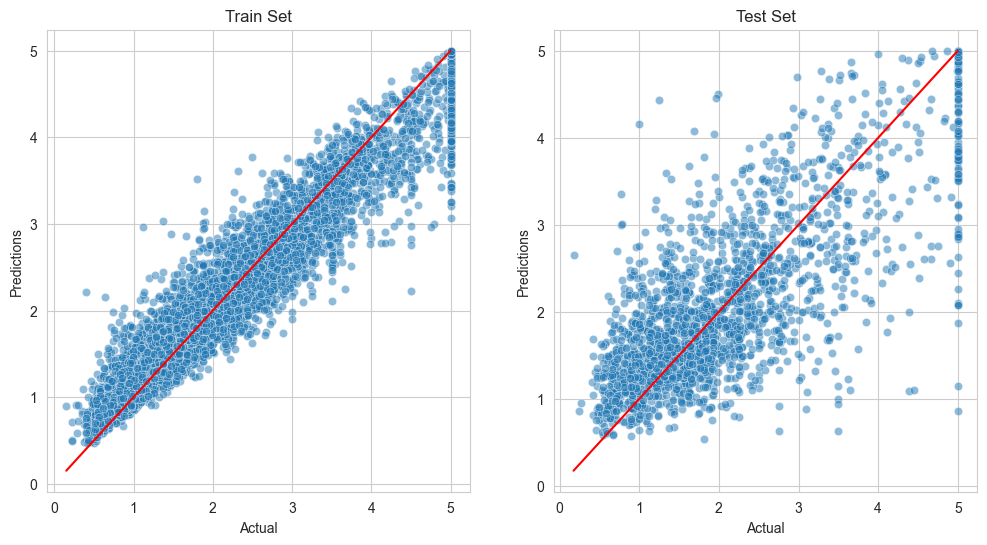

In [12]:
regression_performance(X_train, y_train, X_test, y_test,pipeline)
regression_evaluation_plots(X_train, y_train, X_test, y_test, 
                            pipeline, alpha_scatter=0.5)